In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from skimage.io import imread
from os import path
import os
import pandas as pd
import pickle

import seaborn as sns; sns.set(color_codes=True)

%matplotlib inline

# Data

In [2]:
model_dir = path.join("models", "model2")
log_dir = path.join("data", "rec01")
img_dir = path.join(log_dir, "img")

img_w, img_h, img_ch = 320, 240, 1

In [3]:
drv_log = pd.read_csv(path.join(log_dir, "log.csv"), names=['img', 'speed', 'steer'])

In [4]:
drv_log.head()

,img,speed,steer
0,img_20170725_13_00_46_397840Z.jpg,100,0.070193
1,img_20170725_13_00_46_436273Z.jpg,100,0.070193
2,img_20170725_13_00_46_473557Z.jpg,100,-0.011780
3,img_20170725_13_00_46_513400Z.jpg,100,-0.640675
4,img_20170725_13_00_46_553304Z.jpg,100,-0.132878


In [5]:
drv_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 3 columns):
img      196 non-null object
speed    196 non-null int64
steer    196 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.7+ KB


In [6]:
drv_log.describe()

,speed,steer
count,196.0,196.000000
mean,100.0,0.271016
std,0.0,0.560342
min,100.0,-1.000031
25%,100.0,-0.003967
50%,100.0,0.042848
75%,100.0,1.000000
max,100.0,1.000000


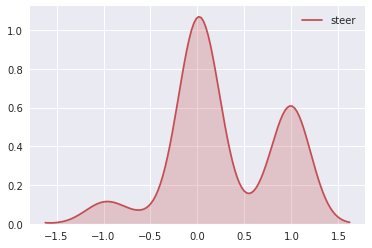

In [7]:
ax = sns.kdeplot(drv_log['steer'], shade=True, color="r")

In [8]:
images = np.zeros((len(drv_log), img_h, img_w, img_ch))
for i, img_name in enumerate(drv_log['img']):
    img = imread(path.join(img_dir, img_name))
    img = np.mean(img, -1)
    images[i] = np.expand_dims(img, -1)

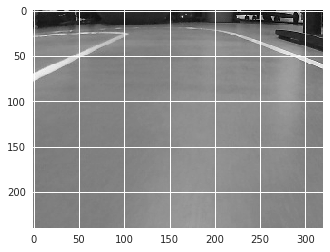

In [9]:
plt.imshow(images[0,:,::-1,0], cmap='gray')

# Model

In [10]:
from keras.models import Sequential
from keras.layers import Lambda, Input, Dense, Conv2D, ELU, Activation, BatchNormalization, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras_tqdm import TQDMNotebookCallback
from utils import RegressionImageDataGenerator

Using TensorFlow backend.


In [11]:
model = Sequential([
    Conv2D(16, 8, strides=(4, 4), padding="same", input_shape=(img_h, img_w, img_ch)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, 3, padding="same"),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, 3, strides=(2, 2), padding="same"),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, 3, padding="same"),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, 3, strides=(2, 2), padding="same"),
    BatchNormalization(),
    Conv2D(128, 3, padding="same"),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, 3, strides=(2, 2), padding="same"),
    BatchNormalization(),
    Activation('relu'),
    
    Flatten(),
    Dropout(0.2),
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(1, activation='tanh')
])

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss="mse")

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 80, 16)        1040      
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 80, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 60, 80, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 80, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 80, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 60, 80, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 40, 32)        9248      
__________

In [13]:
SHIFT_OFFSET = 0.2
SHIFT_RANGE = 0.2

datagen = RegressionImageDataGenerator(horizontal_flip=True,
                                       horizontal_flip_value_transform=lambda val: -val,
                                       channel_shift_range=0.2,
                                       width_shift_range=SHIFT_RANGE,
                                       width_shift_value_transform=lambda val, shift: val - (
                                           (SHIFT_OFFSET / SHIFT_RANGE) * shift))

In [14]:
x_train = images * 2 - 1
y_train = drv_log['steer']

In [15]:
gen = datagen.flow(x_train, y_train, batch_size=128)

In [16]:
def create_dataset_from_gen(gen, data_dir, file, batches):
    size = batches * gen.batch_size
    x = np.zeros((0, *gen.X.shape[1:]))
    y = np.zeros((0, ))
    
    for i, (x_batch, y_batch) in enumerate(gen):
        x = np.append(x, x_batch, axis=0)
        y = np.append(y, y_batch, axis=0)
        
        if i >= batches:
            break
    
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    with open(path.join(data_dir, file), 'wb') as f:
        pickle.dump((x, y), f, pickle.HIGHEST_PROTOCOL)

In [17]:
#create_dataset_from_gen(gen, 'data', 'sample.p', 100)

In [18]:
with open(path.join('data', 'sample.p'), 'rb') as f:
    data = pickle.load(f)

In [19]:
x_train, y_train = data

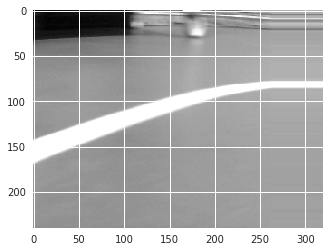

In [20]:
plt.imshow(x_train[0, :, :, 0], cmap='gray')

In [21]:
hist = model.fit(x_train, y_train,
                 epochs=10, verbose=0, batch_size=64,
                 callbacks=[TQDMNotebookCallback()])

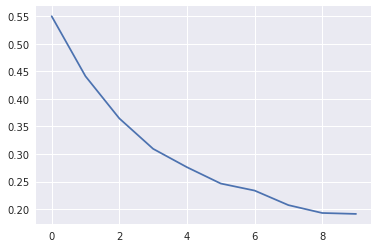

In [22]:
ax = plt.plot(hist.history['loss'])

In [23]:
eval_gen = model.evaluate_generator(gen, 100, workers=4)
eval_gen

1.2871375102656228

In [24]:
eval_train = model.evaluate(x_train, y_train, verbose=0)
eval_train

0.14340449017108592

In [25]:
pred = model.predict(x_train)

In [26]:
result = pd.DataFrame(np.stack((y_train, np.squeeze(pred)), axis=-1), columns=['real', 'pred'])

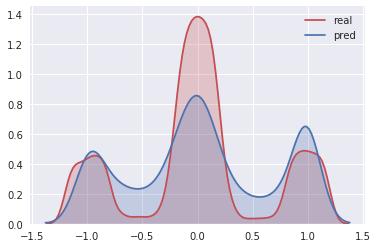

In [27]:
ax = sns.kdeplot(result['real'], shade=True, color="r")
ax = sns.kdeplot(result['pred'], shade=True, color="b")

In [28]:
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_json = model.to_json()
with open(path.join(model_dir, "model.json"), "w") as json_file:
    json_file.write(model_json)

model.save_weights(path.join(model_dir, "model.h5"))
print("Saved model to disk")

Saved model to disk
